In [1]:
import matplotlib.pyplot as plt
import urllib
from bs4 import BeautifulSoup
from selenium import webdriver
from matplotlib import pyplot as plt
%matplotlib inline
import re
import os,sys, shutil
import time
from datetime import date
try:
    import cPickle as pickle
except:
    import pickle
import pprint
from collections import deque
from shutil import copyfile
import random
import glob
# Import the required modules
import cv2, os
import numpy as np
from PIL import Image
from sklearn.cross_validation import KFold
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Logistic Regression
from sklearn import datasets
from sklearn import metrics
import pandas as pd
import math
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

In [2]:
pkl_fl = open("linkedin_profiles.pickle","rb")
my_original_list=pickle.load(pkl_fl) # errors out here
pkl_fl.close()

In [3]:
directory = "Male"
    
if os.path.exists(directory):
    shutil.rmtree(directory)
    os.makedirs(directory)     
else:
    os.makedirs(directory) 

directory1 = "Female"

if os.path.exists(directory1):
    shutil.rmtree(directory1)
    os.makedirs(directory1)     
else:
    os.makedirs(directory1)     

directory2 = "Label_Images_Gender"

if os.path.exists(directory2):
    shutil.rmtree(directory2)
    os.makedirs(directory2)     
else:
    os.makedirs(directory2)     
    
fileList = glob.glob("./Images/*.*")

for id,fp in enumerate(fileList):
    filename, file_extension = os.path.splitext(fp)
    uid = filename.split('/')[-1]
    #print fp
    for prof in my_original_list:
        if prof['User_ID'] == uid:
            new_file_extension = prof['Gender']
            new_file_extension = new_file_extension.title()
            if new_file_extension != 'Unknown':
                copyfile(filename+".jpg", './Label_Images_Gender/'+ uid + '.' + str(id) + "."+new_file_extension +'.jpg')
                copyfile(filename+".jpg", new_file_extension +'/' + uid + ".jpg")

In [3]:
# For face detection we will use the Haar Cascade provided by OpenCV.
cascadePath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascadePath)

# For face recognition we will the the LBPH Face Recognizer 
recognizer = cv2.createLBPHFaceRecognizer()

In [4]:
def get_images_and_labels(path):
    # Append all the absolute image paths in a list image_paths
    
    image_paths = [os.path.join(path, f) for f in os.listdir(path)]
    # images will contains face images
    images = []
    # labels will contains the label that is assigned to the image
    labels = []
    #gender will contains 1 or 0 indecating male or female
    gender =[]
    
    directory = 'face'
    
    if os.path.exists(directory):
        shutil.rmtree(directory)
        os.makedirs(directory)     
    else:
        os.makedirs(directory) 
    
    for image_path in image_paths:
        # Read the image and convert to grayscale
        try:
            image_pil = Image.open(image_path).convert('L')
            # Convert the image format into numpy array
            image = np.array(image_pil, 'uint8')
            # Get the label of the image
        except:
            pass
        
        nbr = int(os.path.split(image_path)[1].split(".")[1])
        gender_current = os.path.split(image_path)[1].split(".")[2]
        #print nbr
        
        # Detect the face in the image
        faces = faceCascade.detectMultiScale(image)
        # If face is detected, append the face to images and the label to labels
        try:
            for (x, y, w, h) in faces:

                ref_image = image[y: y + h, x: x + w]
                resized = cv2.resize(image, (100, 100), interpolation = cv2.INTER_AREA)
                resized_face = cv2.resize(ref_image, (100, 100), interpolation = cv2.INTER_AREA)
                #edge_images = cv2.Canny(resized,100,200)
                
                images.append(np.array(resized_face))   #resized.reshape(1,10000)
                labels.append(nbr)

                if gender_current == 'Male':
                    gender.append(1)
                else:
                    gender.append(0)
                
                face_file_name = "face/" + str(os.path.split(image_path)[1])
                cv2.imwrite(face_file_name, resized_face)
                
                cv2.imshow("Adding faces to traning set...", resized_face)
                cv2.waitKey(1)
        except:
            pass
    # return the images list and labels list
    #print "lables"
    #print labels
    #print "gender_current"
    #print gender
    
    return images, labels, gender

In [5]:
images, labels, gender = get_images_and_labels('Label_Images_Gender')

cv2.destroyAllWindows()

In [6]:
with open("tmp_gender_tensorflow.pickle", "wb") as f:
    pickle.dump((images,labels,gender), f)

In [ ]:
with open("tmp_gender_tensorflow.pickle", "rb") as f:
    images, labels, gender = pickle.load(f)

In [7]:
#res_images = []
res_gender = []

for gen in gender:
    res_gender.append(np.array(gen))

res_gender = np.array(res_gender)

In [8]:
res_gender.shape

(2980,)

## Basic model parameters as external flags.

In [9]:
# Basic model parameters as external flags.
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('max_steps', 2000, 'Number of steps to run trainer.')
flags.DEFINE_integer('hidden1', 1500, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 1000, 'Number of units in hidden layer 2.')
flags.DEFINE_integer('hidden3', 500, 'Number of units in hidden layer 3.')
flags.DEFINE_integer('batch_size', 100, 'Batch size.  '
                     'Must divide evenly into the dataset sizes.')
flags.DEFINE_string('train_dir', 'data', 'Directory to put the training data.')
flags.DEFINE_boolean('fake_data', False, 'If true, uses fake data '
                     'for unit testing.')


NUM_CLASSES = 2
IMAGE_SIZE = 100
#CHANNELS = 3
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE

In [10]:
n_nodes = [IMAGE_PIXELS, 1500, 1000, 500, NUM_CLASSES]
n_epochs = 10

In [11]:
def neural_network_model(data):
    n_hidden_layers = 3
    # define the layers
    layers = [] 
    for i in range(n_hidden_layers + 1):
        layers.append( {'weights':tf.Variable(tf.random_normal([n_nodes[i], n_nodes[i+1]])), 
                        'biases':tf.Variable(tf.random_normal([n_nodes[i+1]]))} )
    
    # calculate the nodal values for each layer
    calcs = [data]
    for i in range(n_hidden_layers):
        calcs.append( tf.nn.relu(tf.matmul(calcs[i], layers[i]['weights']) + layers[i]['biases']) )

    #  return the last layer of nodes
    return tf.matmul(calcs[-1], layers[-1]['weights']) + layers[-1]['biases']

In [12]:
def evaluation(logits, labels):
    correct = tf.nn.in_top_k(logits, labels, 1)
  
    return tf.reduce_sum(tf.cast(correct, tf.int32))

In [13]:
def placeholder_inputs():
    images_placeholder = tf.placeholder(tf.float32, [None,IMAGE_PIXELS])
    labels_placeholder = tf.placeholder(tf.float32, [None,NUM_CLASSES])
    
    return images_placeholder, labels_placeholder


def fill_feed_dict(images_feed,labels_feed, images_pl, labels_pl):
    feed_dict = {
      images_pl: images_feed,
      labels_pl: labels_feed,
    }
  
    return feed_dict

In [14]:
def dense_to_one_hot(labels_dense, num_classes):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    
    return labels_one_hot

In [15]:
def main():
    # Tell TensorFlow that the model will be built into the default Graph.
    with tf.Graph().as_default():
        # Generate placeholders for the images and labels.
        images_placeholder, labels_placeholder = placeholder_inputs()

        
        logits = neural_network_model(images_placeholder)
        
        #cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels_placeholder, name='xentropy')
        #cost = tf.reduce_mean(cross_entropy, name='xentropy_mean')
        
        cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits,labels_placeholder) )
        training_acc = []
        testing_acc = []
       
        #print cost
        optimizer = tf.train.AdamOptimizer(1e-4).minimize(cost)

        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())
        
        # And then after everything is built, start the training loop.
            
            subset_size = 256
            for step in xrange(200):
                start_time = time.time()
                total_loss = 0
                for i in range(int(train_images.shape[0] / subset_size) ):
                    
                    epoch_x = train_images[i * subset_size:][:subset_size]
                    epoch_y = train_labels[i * subset_size:][:subset_size]
                    
                    feed_dict = fill_feed_dict(epoch_x, epoch_y, images_placeholder, labels_placeholder)
                    
                    _, loss_value = sess.run([optimizer, cost],
                                           feed_dict=feed_dict)
                    
                    total_loss+=loss_value
                    
                duration = time.time() - start_time
                #if step % 10 == 0:
                    #Print status to stdout.
                correct = tf.equal(tf.argmax(logits,1), tf.argmax(labels_placeholder,1))
                #print correct
                accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
                
                print('Step %d: loss = %.2f (%.3f sec)' % (step, total_loss, duration)),
                
                current_train_acc = accuracy.eval({images_placeholder: train_images, labels_placeholder: train_labels})
                current_test_acc = accuracy.eval({images_placeholder: test_images, labels_placeholder: test_labels})
                
                training_acc.append(current_train_acc)
                testing_acc.append(current_test_acc)
                
                
                print('Training Accuracy:', current_train_acc),
                print('Testing Accuracy:', current_test_acc)
    
    return training_acc, testing_acc

In [16]:
# Get the sets of images and labels for training, validation, and

images = np.array(images)
images = images.reshape(images.shape[0],IMAGE_PIXELS)

#label = res_gender
labels = dense_to_one_hot(res_gender,2)

In [17]:
train_images = images[:-300]
train_labels = labels[:-300]
test_images = images[-300:]
test_labels = labels[-300:]

In [18]:
train_images.shape

(2680, 10000)

In [19]:
train_labels.shape

(2680, 2)

In [84]:
if __name__ == '__main__':
    train_acc_whole_image, test_acc_whole_image = main()

Step 0: loss = 270972768.00 (8.142 sec) ('Training Accuracy:', 0.51455224) ('Testing Accuracy:', 0.52999997)
Step 1: loss = 196890163.00 (7.765 sec) ('Training Accuracy:', 0.58619404) ('Testing Accuracy:', 0.61000001)
Step 2: loss = 152967398.00 (7.769 sec) ('Training Accuracy:', 0.63208956) ('Testing Accuracy:', 0.64999998)
Step 3: loss = 126975156.00 (8.511 sec) ('Training Accuracy:', 0.64664179) ('Testing Accuracy:', 0.63999999)
Step 4: loss = 112515974.00 (8.522 sec) ('Training Accuracy:', 0.65820897) ('Testing Accuracy:', 0.64666665)
Step 5: loss = 101201192.00 (8.489 sec) ('Training Accuracy:', 0.66567165) ('Testing Accuracy:', 0.64666665)
Step 6: loss = 91702610.00 (8.517 sec) ('Training Accuracy:', 0.68507463) ('Testing Accuracy:', 0.62666667)
Step 7: loss = 83602773.00 (8.543 sec) ('Training Accuracy:', 0.69253731) ('Testing Accuracy:', 0.63)
Step 8: loss = 76173784.00 (8.702 sec) ('Training Accuracy:', 0.70559704) ('Testing Accuracy:', 0.63999999)
Step 9: loss = 69487701.00 (

In [20]:
if __name__ == '__main__':
    train_acc_face, test_acc_face = main()

Step 0: loss = 530957034.00 (7.833 sec) ('Training Accuracy:', 0.55447763) ('Testing Accuracy:', 0.53666669)
Step 1: loss = 225841179.00 (7.505 sec) ('Training Accuracy:', 0.54626864) ('Testing Accuracy:', 0.55333334)
Step 2: loss = 141243949.00 (7.498 sec) ('Training Accuracy:', 0.65895522) ('Testing Accuracy:', 0.66333336)
Step 3: loss = 114297752.00 (7.344 sec) ('Training Accuracy:', 0.64701492) ('Testing Accuracy:', 0.63)
Step 4: loss = 87723113.00 (7.997 sec) ('Training Accuracy:', 0.67611939) ('Testing Accuracy:', 0.67666668)
Step 5: loss = 76319744.50 (8.014 sec) ('Training Accuracy:', 0.67947763) ('Testing Accuracy:', 0.67666668)
Step 6: loss = 69800254.50 (7.998 sec) ('Training Accuracy:', 0.68731344) ('Testing Accuracy:', 0.69999999)
Step 7: loss = 63875468.50 (8.019 sec) ('Training Accuracy:', 0.69999999) ('Testing Accuracy:', 0.70333332)
Step 8: loss = 58704504.75 (8.031 sec) ('Training Accuracy:', 0.70373136) ('Testing Accuracy:', 0.70333332)
Step 9: loss = 54707788.50 (8.

In [113]:
max(test_acc)

0.81

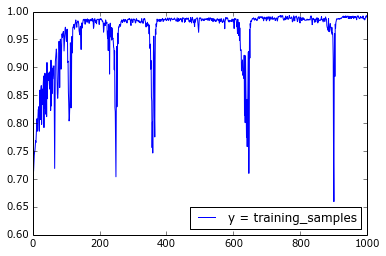

In [109]:
x = np.arange(1000)

plt.plot(x, train_acc)
#plt.plot(x, test_acc)


plt.legend(['y = training_samples', 'y = testing_samples'], loc='lower right')

plt.show()

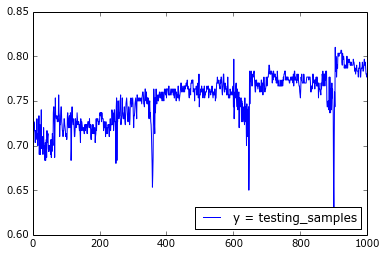

In [110]:
x = np.arange(1000)

plt.plot(x, test_acc)


plt.legend(['y = testing_samples'], loc='lower right')

plt.show()

In [116]:
accuracy_list = pd.DataFrame(
    {'Training_Acc': train_acc,
     'Testing_Acc': test_acc,
    })

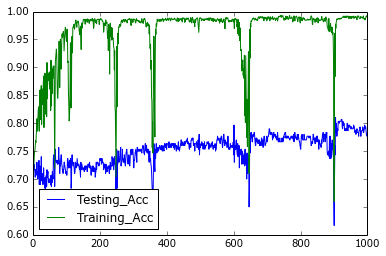

In [117]:
accuracy_list.plot()

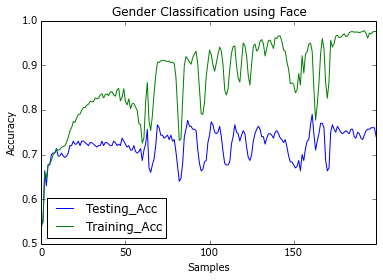

In [25]:
accuracy_list_face = pd.DataFrame(
    {'Training_Acc': train_acc_face,
     'Testing_Acc': test_acc_face,
    })
ax = accuracy_list_face.plot(title='Gender Classification using Face')
ax.set_xlabel("Samples")
ax.set_ylabel("Accuracy")

In [85]:
accuracy_list_whole = pd.DataFrame(
    {'Training_Acc': train_acc_whole_image,
     'Testing_Acc': test_acc_whole_image,
    })

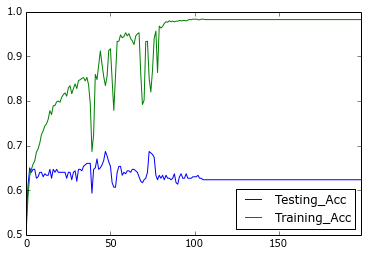

In [86]:
accuracy_list_whole.plot()